In [1]:
from scipy.integrate import odeint
from scipy.stats import lognorm
import numpy as np
from ode_api import *
from ode_funcs import *
import matplotlib.pyplot as plt
import scipy
import pymc3 as pm
import pprint

THEANO_FLAGS = 'exception_verbosity=high'
THEANO_FLAGS='optimizer=fast_compile'
theano.config.exception_verbosity= 'high'
theano.config.floatX = 'float64'

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


# Test 1: Vector ODE with 1 parameter

$$ S' = -\mathcal{R}_0 SI \quad S(0) = 0.99 $$
$$ I' = \mathcal{R}_0 SI - I \quad I(0) = 0.01 $$

In [2]:
#Specify how many stats, initial values, and ode parameters there are
n_states = 2
n_odeparams = 1

data = make_test_data_3()
#Times to evaluate the solution
times = data['t']

#Instantiate the ODEModel
ode_model = ODEModel(func = test_ode_func_3, 
                    t0 = 0,
                    times = times,
                    n_states = n_states,
                    n_odeparams = n_odeparams)

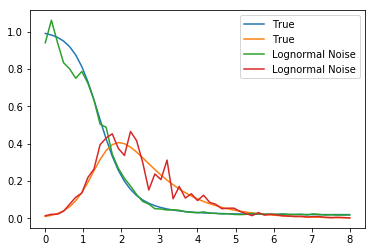

In [3]:
Ytrue = data['y']
Y = data['yobs']

plt.plot(times,Ytrue, label = 'True')
plt.plot(times,Y, label = 'Lognormal Noise')
plt.legend()



In [4]:

    
my_ODEop = ODEop(ode_model)


In [5]:
# The probabilistic model
with pm.Model() as first_model:

    # Priors for unknown model parameters
    R = pm.Bound(pm.Normal, lower=1)('R', mu = 1, sd = 2)

    sigma = pm.HalfCauchy('sigma',1, shape = 2)

    # Forward model
    #[ODE Parameters, initial condition]
    all_params = pm.math.stack([R,0.99, 0.01],axis=0)

    
    ode_sol = my_ODEop(all_params)

    
    forward = ode_sol.reshape(Y.shape)

    
    ode = pm.Deterministic('ode',ode_sol)
    
    

    # Likelihood 
    Y_obs = pm.Lognormal('Y_obs', mu=pm.math.log(forward), sd=sigma, observed=Y)

    
    trace = pm.sample(2000, tune=1000, init='adapt_diag', target_accept = 0.99)



Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, R]
Sampling 2 chains: 100%|██████████| 6000/6000 [15:57<00:00,  5.55draws/s] 


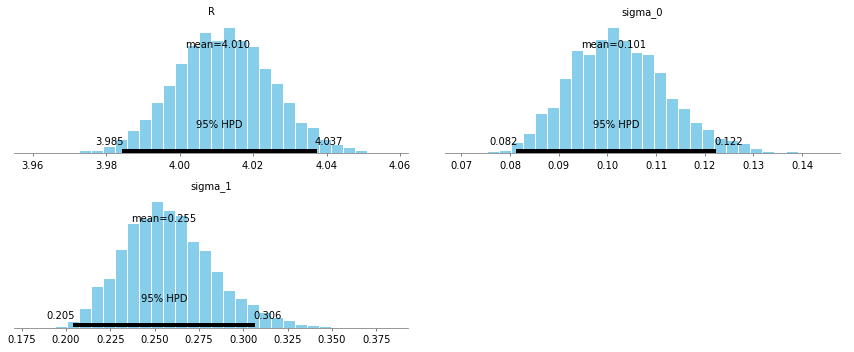

In [8]:

pm.posteriorplot.plot_posterior(trace, varnames=['R','sigma']);

In [9]:
pprint.pprint(pm.gelman_rubin(trace))

pprint.pprint(pm.effective_n(trace))

{'R': 1.000216767483172,
 'ode': array([0.99974997, 0.99974997, 1.00021629, 1.00021628, 1.00021584,
       1.00021581, 1.00021544, 1.00021539, 1.00021512, 1.00021507,
       1.00021495, 1.00021489, 1.00021498, 1.00021496, 1.00021529,
       1.00021535, 1.00021589, 1.00021612, 1.00021673, 1.00021727,
       1.00021769, 1.00021878, 1.00021863, 1.00022074, 1.00021945,
       1.00022372, 1.00022011, 1.00023133, 1.00022059, 1.00011111,
       1.00022092, 1.00020796, 1.00022113, 1.00021354, 1.00022126,
       1.00021565, 1.00022132, 1.0002168 , 1.00022133, 1.00021753,
       1.00022132, 1.00021804, 1.00022128, 1.00021842, 1.00022122,
       1.00021871, 1.00022116, 1.00021895, 1.0002211 , 1.00021915,
       1.00022103, 1.00021931, 1.00022096, 1.00021945, 1.0002209 ,
       1.00021957, 1.00022084, 1.00021968, 1.00022078, 1.00021978,
       1.00022072, 1.00021987, 1.00022067, 1.00021995, 1.00022063,
       1.00022003, 1.00022058, 1.0002201 , 1.00022054, 1.00022016,
       1.00022051, 1.00022023

In [10]:
with first_model:
    ppc = pm.sample_ppc(trace, 500)

/Users/demetri/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 500/500 [00:25<00:00, 19.64it/s]


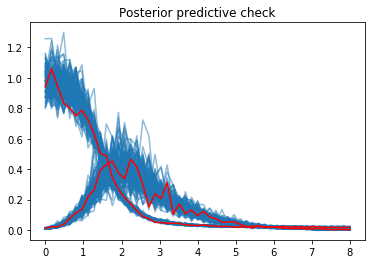

In [11]:
yobs = ppc['Y_obs']
for i in range(100):

    plt.plot(times, yobs[i], color = 'C0', alpha = 0.5)
    
plt.plot(times,Y, color = 'red')
plt.title('Posterior predictive check');

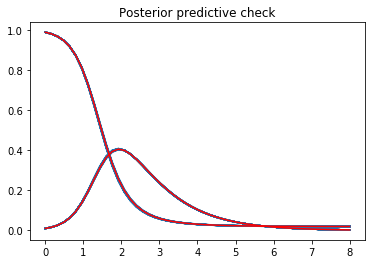

In [12]:
yobs = trace['ode']
for i in range(100):

    plt.plot(times, yobs[i].reshape(Y.shape), color = 'C0', alpha = 0.5)
    
plt.plot(times,Ytrue, color = 'red')
plt.title('Posterior predictive check');